# Avg Bias vs. Lead Time Plot

plot the differnece between the AI forecast and ERA5 2 meter temperature as a function of of lead time (how far into the forecast is this prediction accurate)

In [1]:
# Suppress warnings
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

# Direct access
import s3fs

# datetime
import datetime as dt

# api to read files
import dask.array as da
import xarray as xr
import h5py

# data process
import numpy as np
import pandas as pd

# plot
import matplotlib.pyplot as plt
import matplotlib.animation as anim

import cartopy.crs as ccrs
import cartopy.feature as cfeature

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [4]:
days = 10 
dd_list = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10']

s3 = s3fs.S3FileSystem(anon=True) # connect to s3

lon_list = []
lat_list = []
t2_list = []
time_list = []

for day in range(days):
    url_parents = 's3://noaa-oar-mlwp-data' # the format of the full url is s3://bucket/yyyy/mm/dd/Radar_id/filename
    model = 'PANG_v100'
    yyyy = '2023'
    mm = '07'
    dd = dd_list[day]
    url_radar_search = url_parents +'/'+model+'/' +yyyy + '/' + mm + '/' + dd + '/' # the format of the full url is s3://bucket/yyyy/mm/dd/Radar_id/filename
    
    url_radar_date = s3.ls(url_radar_search) # list all the files in the folder
    
    aws_file = 's3://' + url_radar_date[0]
    
    f = s3.open(aws_file, 'rb') # open the file
    
    ds = xr.open_dataset(f, chunks={'time': 10, 'lat': 50, 'lon': 50}, engine='h5netcdf') # read the file

    lon = ds.variables['longitude'][:]
    lon_list.append(lon)
    
    lat = ds.variables['latitude'][:]
    lat_list.append(lat)
    
    t2_PANG = ds.variables['t2'][:]
    t2_list.append(t2_PANG)
    
    time = ds.variables['time'][:]
    time_list.append(time)
    

EndpointConnectionError: Could not connect to the endpoint URL: "https://noaa-oar-mlwp-data.s3.amazonaws.com/?list-type=2&prefix=PANG_v100%2F2023%2F07%2F01%2F&delimiter=%2F&encoding-type=url"

In [5]:
time_list[5][16] # test to check if i loaded the data correctly, should read 2023-07-10 00 UTC

IndexError: list index out of range

## Observation Data

In [6]:
era5_ds = xr.open_dataset('ERA5_data/20230701.part')
lon_era = era5_ds.variables['longitude'][:]
lat_era = era5_ds.variables['latitude'][:]
t2_ERA5 = era5_ds.variables['t2m'][36,:,:]
era_time =  era5_ds.variables['time'][36]
t2_ERA5

<xarray.Variable (latitude: 721, longitude: 1440)>
[1038240 values with dtype=float32]
Attributes:
    units:      K
    long_name:  2 metre temperature

In [ ]:
datetime = pd.to_datetime(time_list[0].data, unit='s')
datetime

## Plot

In [ ]:
LT_list = []
for day in range(days):
    LT = datetime[4*day]
    LT_list.append(LT)
    
LT_list

In [60]:
bias_list = []

for day in range(days):
    bias = t2_list[day][36-(4*day)] - t2_ERA5
    bias_list.append(bias)
    
bias_list

[<xarray.Variable (latitude: 721, longitude: 1440)>
 dask.array<sub, shape=(721, 1440), dtype=float32, chunksize=(721, 1440), chunktype=numpy.ndarray>,
 <xarray.Variable (latitude: 721, longitude: 1440)>
 dask.array<sub, shape=(721, 1440), dtype=float32, chunksize=(721, 1440), chunktype=numpy.ndarray>,
 <xarray.Variable (latitude: 721, longitude: 1440)>
 dask.array<sub, shape=(721, 1440), dtype=float32, chunksize=(721, 1440), chunktype=numpy.ndarray>,
 <xarray.Variable (latitude: 721, longitude: 1440)>
 dask.array<sub, shape=(721, 1440), dtype=float32, chunksize=(721, 1440), chunktype=numpy.ndarray>,
 <xarray.Variable (latitude: 721, longitude: 1440)>
 dask.array<sub, shape=(721, 1440), dtype=float32, chunksize=(721, 1440), chunktype=numpy.ndarray>,
 <xarray.Variable (latitude: 721, longitude: 1440)>
 dask.array<sub, shape=(721, 1440), dtype=float32, chunksize=(721, 1440), chunktype=numpy.ndarray>,
 <xarray.Variable (latitude: 721, longitude: 1440)>
 dask.array<sub, shape=(721, 1440), 

In [69]:
t2_list[0][36,:,:]

<xarray.Variable (latitude: 721, longitude: 1440)>
dask.array<getitem, shape=(721, 1440), dtype=float32, chunksize=(721, 1440), chunktype=numpy.ndarray>
Attributes:
    long_name:  2 metre temperature
    units:      K

In [73]:
t2_list[9]

<xarray.Variable (time: 41, latitude: 721, longitude: 1440)>
dask.array<open_dataset-t2, shape=(41, 721, 1440), dtype=float32, chunksize=(10, 721, 1440), chunktype=numpy.ndarray>
Attributes:
    long_name:  2 metre temperature
    units:      K

In [62]:
avg_bias_list = []
var_bias_list = []
for day in range(days):
    avg_bias = np.mean(bias_list[day])
    var_bias = np.var(bias_list[day])
    avg_bias_list.append(avg_bias)
    var_bias_list.append(var_bias)

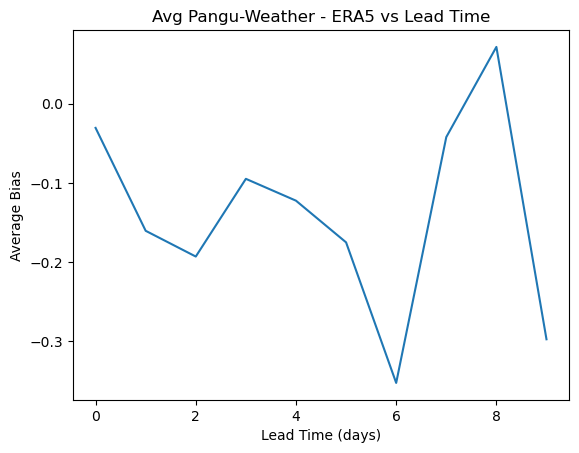

In [63]:
plt.figure()
plt.plot(LT_list, avg_bias_list)
plt.xlabel('Lead Time (days)')
plt.ylabel('Average Bias (Temp (kelvin))')
plt.title('Avg Pangu-Weather - ERA5 vs Lead Time')
plt.show()

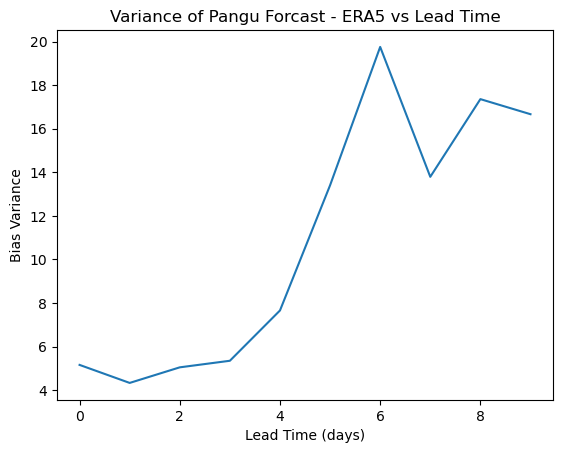

In [64]:
plt.figure()
plt.plot(LT_list, var_bias_list)
plt.xlabel('Lead Time (days)')
plt.ylabel('Bias Variance')
plt.title("Variance of Pangu Forcast - ERA5 vs Lead Time")
plt.show()

In [65]:
def rmse(predictions, targets):
    return np.sqrt(np.mean((predictions-targets)**2))

In [70]:
rmse_list = []

for day in range(days):
    rmse = np.sqrt(np.mean(t2_list[day][36-(4*day),:,:], t2_ERA5))
    rmse_list.append(rmse)
rmse_list

ValueError: operands could not be broadcast together with shapes (721,1440) (0,) 